# Requirements

In [26]:
import pandas as pd
import numpy as np
import geopandas as gpd

import tempun

from scipy.spatial import cKDTree
from pyproj import Geod
from shapely.geometry import LineString

import nltk
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.lines as mlines
from matplotlib.patches import Patch
import seaborn as sns
import geoplot as gplt

# Import datasets

In [16]:
LIRE = gpd.read_parquet("../data/large_data/LIRE_occupsorgs_cats.parquet")

In [27]:
%%time
# generate a list of 1000 random dates for each inscription in the dataset
# takes approx. 90 seconds in Google colab
LIRE["random_dates"] = LIRE.apply(lambda row: tempun.model_date(row["not_before"], row["not_after"], size=1000), axis=1)

CPU times: user 41.9 s, sys: 1.9 s, total: 43.8 s
Wall time: 44.9 s


In [113]:
roman_cities = gpd.read_file("../data/roman_cities_pop.geojson")
pleiades_regions = gpd.read_file("../data/pleiades_regions.geojson")
pleiades_regions_west = gpd.read_file("../data/pleiades_regions_west.geojson")

# Map inscriptions on cities

In [114]:
def get_my_city(row):
    context = row["urban_context_alt"]
    try:
        ID = row[context + "_city_ID"]
    except:
        ID = None
    return ID
LIRE["city_ID"] = LIRE.apply(lambda row: get_my_city(row), axis=1)

In [115]:
city_data = LIRE[LIRE["city_ID"]=="97"]
city_data

,EDCS-ID,publication,province,province_list,place,place_list,end_yr_list,notes_dating,status_list,inscr_type,...,small_city_geo,small_city_dist,urban_context_alt,occups,occups_N,organizations,organizations_N,occups_cats,city_ID,random_dates
1,EDCS-03300852,"AE 1995, 01409",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",276,to 276; b: 276 to 282 \n\n,"['Augusti/Augustae', 'miliaria', 'viri']",miliaria,...,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[],97,"[276, 276, 276, 276, 276, 276, 276, 276, 276, ..."
2,EDCS-28500283,"CIL 03, 07251 = D 00214 = NDIEC-07, p 81 = AE ...",Achaia,Achaia,Alea / Tegea,"['Alea', 'Tegea']",50,,"['Augusti/Augustae', 'leges', 'viri']",leges,...,"[22.336587, 37.462155]",7876.09,large,[],0,[],0,[],97,"[49, 49, 50, 50, 49, 49, 49, 49, 50, 50, 49, 5..."


In [116]:
def get_inscriptions(ID):
    city_dict = {}
    city_data = LIRE[LIRE["city_ID"]==str(ID)]
    if len(city_data) > 0:
        city_dict["inscr_N"] = len(city_data)
        inscr_texts = city_data["clean_text_interpretive_word"].tolist()
        inscr_texts = [el for el in inscr_texts if isinstance(el, str)]
        city_dict["inscr_texts_wordlist"] = " ".join(inscr_texts).split()
        city_dict["edcs_ids"] = city_data["EDCS-ID"].tolist()
        city_dict["edh_ids"] = city_data["EDH-ID"].tolist()
        city_dict["inscr_with_occups"] = (city_data["occups_N"]>0).sum()
        city_dict["random_dates"] = city_data["random_dates"].tolist()
        city_dict["occups_mask"] = city_data["occups_N"] > 0
        city_dict["occups_list"] = [el for sublist in city_data["occups"] for el in sublist]
        city_dict["occups_N"] = city_data["occups_N"].sum()
        city_dict["occups_cats_list"] = [el for sublist in city_data["occups_cats"] for el in sublist]
    return city_dict

cities_dict_data = roman_cities["ID"].apply(get_inscriptions)

In [117]:
cities_inscr_data = pd.DataFrame(cities_dict_data.tolist())
cities_inscr_data.head(5)

,inscr_N,inscr_texts_wordlist,edcs_ids,edh_ids,inscr_with_occups,random_dates,occups_mask,occups_list,occups_N,occups_cats_list
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,"[Caius, Varius, Stratullus, Γάϊος, Οὐάριος, Στ...",[EDCS-45800005],[HD006767],0.0,"[[35, 65, 48, 69, 78, 24, 97, 47, 5, 23, 67, 9...","192 False Name: occups_N, dtype: bool",[],0.0,[]
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [118]:
roman_cities = pd.concat([roman_cities, cities_inscr_data], axis=1)

# Explore inscriptions within cities

In [119]:
roman_cities.head(5)

,Primary Key,Ancient Toponym,Modern Toponym,Province,Country,Barrington Atlas Rank,Barrington Atlas Reference,Start Date,End Date,Select Bibliography,...,inscr_N,inscr_texts_wordlist,edcs_ids,edh_ids,inscr_with_occups,random_dates,occups_mask,occups_list,occups_N,occups_cats_list
0,Hanson2016_1,Abae,Kalapodi,Achaea,Greece,4 or 5,55 D3,-600,NaN,BNP; Hansen 2006; Hansen and Nielsen 2004; PEC...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Hanson2016_2,Acharnae,Acharnes,Achaea,Greece,3,59 B2,-600,NaN,BNP; DGRG; PECS; Sear 2006.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Hanson2016_3,Acraephia,Akraifnio,Achaea,Greece,3,55 E4,-600,NaN,BNP; DGRG; Hansen and Nielsen 2004; PECS; Sear...,...,1.0,"[Caius, Varius, Stratullus, Γάϊος, Οὐάριος, Στ...",[EDCS-45800005],[HD006767],0.0,"[[35, 65, 48, 69, 78, 24, 97, 47, 5, 23, 67, 9...","192 False Name: occups_N, dtype: bool",[],0.0,[]
3,Hanson2016_4,Aegina,Aigina,Achaea,Greece,2,59 A3,-600,NaN,BNP; DGRG; Hansen 2006; Hansen and Nielsen 200...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Hanson2016_5,Aegira,Aigeira,Achaea,Greece,3,58 C1,-600,NaN,DGRG; Hansen and Nielsen 2004.,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [120]:
# all cities
len(roman_cities)

1388

In [121]:
roman_cities["inscr_N"].sum()

110163.0

In [122]:
# cities with at least one inscription
(roman_cities["inscr_N"]>0).sum()

856

In [123]:
# proportion of cities with at least one inscription
(roman_cities["inscr_N"]>0).mean()

0.6167146974063401

In [124]:
# N western cities
(roman_cities["western_province"]).sum()

889

In [125]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum()

657

In [126]:
((roman_cities["western_province"]) & (roman_cities["inscr_N"]>0)).sum() / (roman_cities["western_province"]).sum()

0.7390326209223848

# Focus on western cities alone

In [127]:
roman_cities = roman_cities[roman_cities["western_province"]]
len(roman_cities)

889

In [128]:
roman_cities["inscr_N"].sum()

103237.0

In [129]:
np.log(roman_cities["pop_est"])

156      6.907755
157      6.907755
158      8.484050
159      6.907755
160      6.907755
          ...    
1317     8.405367
1318     7.351800
1319    11.336558
1320     9.311090
1321     8.278174
Name: pop_est, Length: 889, dtype: float64

In [143]:
roman_cities["pop_est_log"] = np.log(roman_cities["pop_est"])
roman_cities["inscr_N_log"] = np.log(roman_cities["inscr_N"])

roman_cities["pop_est_log10"] = np.log10(roman_cities["pop_est"])
roman_cities["inscr_N_log2"] = np.log2(roman_cities["inscr_N"])

roman_cities["occups_N_log"] = np.log2(roman_cities["occups_N"])


/Users/kasev/Projects/social_diversity/socdiv_venv/lib/python3.10/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log2
  result = getattr(ufunc, method)(*inputs, **kwargs)


<AxesSubplot:xlabel='inscr_N', ylabel='pop_est'>

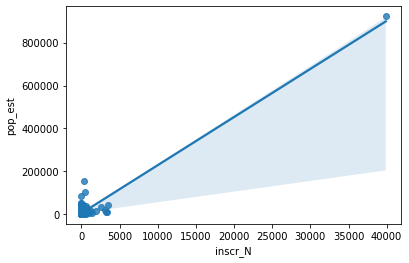

In [131]:
# all cities
data=roman_cities
sns.regplot(x="inscr_N", y="pop_est", data=data)

<AxesSubplot:xlabel='inscr_N', ylabel='pop_est'>

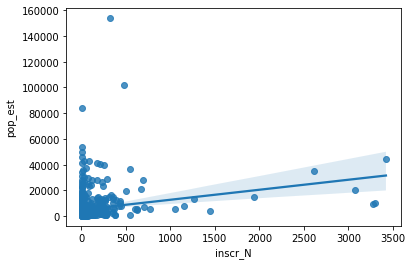

In [132]:
# cities without Roma
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N", y="pop_est", data=data)

<AxesSubplot:xlabel='inscr_N', ylabel='pop_est_log'>

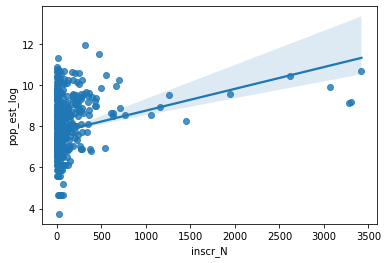

In [133]:
# cities without Roma, POP LOG
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N", y="pop_est_log", data=data)

<AxesSubplot:xlabel='inscr_N_log', ylabel='pop_est_log'>

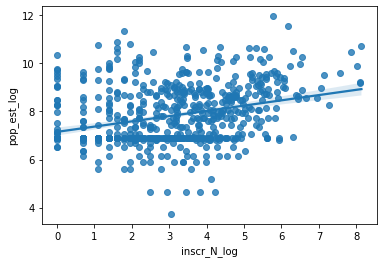

In [134]:
# cities without Roma, POP LOG
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N_log", y="pop_est_log", data=data)

<AxesSubplot:xlabel='inscr_N', ylabel='num_of_structures'>

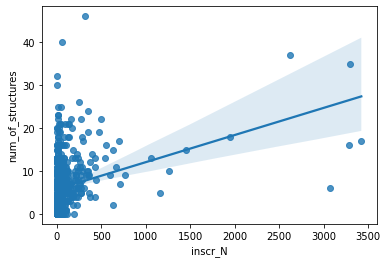

In [135]:
# cities without Roma, POP LOG
data=roman_cities[roman_cities["Ancient Toponym"]!="Roma"]
sns.regplot(x="inscr_N", y="num_of_structures", data=data)

<AxesSubplot:xlabel='occups_N', ylabel='num_of_structures'>

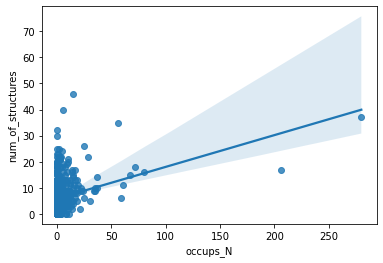

In [142]:
# cities without Roma, POP LOG
data=roman_cities[
    (roman_cities["Ancient Toponym"]!="Roma")
    ]
sns.regplot(x="occups_N", y="num_of_structures", data=data)

<AxesSubplot:xlabel='occups_N', ylabel='num_of_structures'>

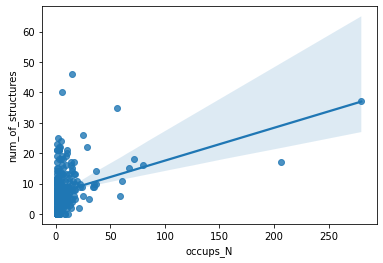

In [141]:
# cities without Roma, POP LOG
data=roman_cities[
    (roman_cities["Ancient Toponym"]!="Roma")
    & (roman_cities["occups_N"]>0)
]
sns.regplot(x="occups_N", y="num_of_structures", data=data)

In [151]:
roman_cities["occups_N_log"].tolist()

[-inf,
 -inf,
 -inf,
 0.0,
 nan,
 nan,
 nan,
 nan,
 -inf,
 2.321928094887362,
 nan,
 nan,
 nan,
 -inf,
 nan,
 3.169925001442312,
 nan,
 nan,
 0.0,
 -inf,
 -inf,
 1.0,
 -inf,
 3.9068905956085187,
 nan,
 0.0,
 nan,
 1.584962500721156,
 -inf,
 nan,
 -inf,
 nan,
 -inf,
 3.0,
 0.0,
 -inf,
 0.0,
 1.584962500721156,
 -inf,
 -inf,
 -inf,
 0.0,
 nan,
 nan,
 nan,
 2.584962500721156,
 0.0,
 nan,
 0.0,
 nan,
 -inf,
 nan,
 nan,
 nan,
 -inf,
 nan,
 nan,
 nan,
 -inf,
 -inf,
 nan,
 nan,
 0.0,
 nan,
 -inf,
 nan,
 3.169925001442312,
 1.0,
 0.0,
 -inf,
 2.807354922057604,
 0.0,
 0.0,
 nan,
 nan,
 -inf,
 2.0,
 -inf,
 -inf,
 nan,
 0.0,
 nan,
 -inf,
 3.4594316186372973,
 -inf,
 nan,
 4.857980995127572,
 -inf,
 0.0,
 0.0,
 nan,
 -inf,
 0.0,
 -inf,
 -inf,
 -inf,
 0.0,
 0.0,
 -inf,
 nan,
 -inf,
 nan,
 -inf,
 nan,
 -inf,
 2.0,
 nan,
 nan,
 -inf,
 0.0,
 -inf,
 -inf,
 -inf,
 nan,
 1.0,
 1.0,
 nan,
 1.584962500721156,
 0.0,
 -inf,
 -inf,
 1.584962500721156,
 -inf,
 4.906890595608519,
 2.321928094887362,
 -inf,
 -i

<AxesSubplot:xlabel='occups_N_log', ylabel='pop_est_log'>

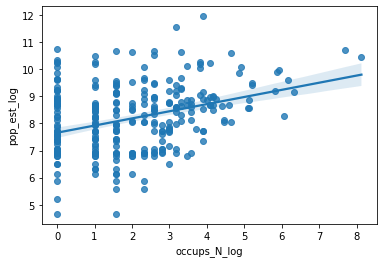

In [166]:
# cities without Roma, POP LOG
data=roman_cities[
    (roman_cities["Ancient Toponym"]!="Roma")
    & (roman_cities["occups_N"]>0)
]
sns.regplot(x="occups_N_log", y="pop_est_log", data=data)